### Import Required Libraries

In [1]:
import numpy as np
from numpy.random import shuffle
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline,LinearNDInterpolator
from scipy.optimize import fsolve
import time
import pandas as pd
import os
from sklearn.linear_model import LinearRegression

### Viscous_parameters_solver Function

In [2]:
def viscous_parameters_solver(t, theta,mobject):
    l = 0.6505
    r = 0.36115625
    g = 9.7949
    mnet = 2.974+mobject #FIRST NUMBER IS DISK AND SENSOR, NOT INCLUDING TRANSMITTER
    noise_param = 0.04

    # Trim NaN values from t and theta
    validIndicies = ~np.isnan(theta)
    t = t[validIndicies]
    theta = theta[validIndicies]

    # Filter the data
    b, a = butter(3, 0.05, 'low')
    filtered_theta = filtfilt(b, a, theta)
    
    peak_filtering_param = 3 #remember to adjust as to remove outliers associated with signal noise

    # Use find_peaks with adjusted parameters to identify peaks
    peaks, _ = find_peaks(filtered_theta, prominence=np.deg2rad(noise_param*peak_filtering_param))  # adjust prominence if needed

    # Check if peaks are found
    if len(peaks) == 0:
        print("No peaks were found.")
        return [0, 0, 0, 0]

    # Calculate the periods between peaks
    periods = np.diff(t[peaks])
    # plt.figure()
    # plt.plot(t,theta,'kx',ms=1)
    # plt.plot(t,filtered_theta,'r-')
    # plt.xlim((0,15))
    # plt.show()
    # plt.figure()
    # plt.plot(periods)
    # plt.show()
    # Calculate median filtered period
    T_d = np.median(periods)
    # print(f"T_d = {T_d}", end='\n')
    omega_d = (2 * np.pi) / T_d
    # print(f"Calculated wd = {omega_d}", end='\n')

    # Calculate the damping ratio
    amplitude_ratios = filtered_theta[peaks][1:] / filtered_theta[peaks][:-1]
    damping_ratios = -1*np.log(amplitude_ratios)
    # print(f"Calculated dr = {np.median(damping_ratios)}",end='\n')
    zeta = np.median(damping_ratios) / ( np.sqrt( (4 * np.pi ** 2) + (np.median(damping_ratios) ** 2) ) )
    # print(f"Calculated zeta = {zeta}",end='\n')

    # Calculate natural frequency and inertia
    omega_n = omega_d / np.sqrt(1 - zeta ** 2)
    Inet_pure = (mnet * g * r ** 2) / (l * omega_n ** 2)
    c_pure = zeta * 2 * np.sqrt(Inet_pure * ((mnet * g * r ** 2) / l))

    return [Inet_pure, (mnet * g * r ** 2) / l, c_pure, 0]


#### Calculating Disk Inertia, Known Inertia Values

In [3]:
# # Importing Disk Data
folder_path = '/home/coder/workspace/Finnamore/Mass_Calibration'
disk_path = '/home/coder/workspace/Finnamore/Mass_Calibration'
numTests = 45
df_disk_data = {}
disk_inertia_data = np.zeros(numTests)
disk_period_data = np.zeros(numTests)

# Importing and Calculating Disk Inertial Data
for i in range(numTests):
    # File Path Creation
    file_name = 'I_D_{:02}.csv'.format(i)
    file_path = os.path.join(disk_path,file_name)

    #Reading in Data
    df = pd.read_csv(file_path,usecols=[0,1])
    df_disk_data[i] = df.values

    #Solving for Disk Inertia
    
    disk_inertia_data[i] = viscous_parameters_solver(df_disk_data[i][:,0],df_disk_data[i][:,1],0)[0]

#Setting up Dicitonary of Known Inertial Values
disk_inertia = np.median(disk_inertia_data)
disk_period = np.median(disk_period_data)
I_names = ['1.176','.4465']
print(disk_inertia)
# Calculating and Storing Known Inertial Values

actual_inertias = {}
actual_inertias['1.176'] = 2*(1.176*(0.185**2)+(0.5*1.176*((0.045/2)**2)))
actual_inertias['.4465'] = 2*(0.4465*(0.3**2)+(0.5*0.4465*((0.051/2)**2)))



0.20011481790010444


### Import Data


In [4]:
raw_data = {}
inertia_data = {}
period_data = {}
# Define the pattern or names of your CSV files
for name in I_names:
    raw_data[name] = {}
    inertia_data[name] = np.zeros(numTests)
    period_data[name] = np.zeros(numTests)
    for i in range(numTests):
        file_name = ('I_{}_{:02}.csv'.format(name,i))
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path, usecols=[0, 1])
        raw_data[name][i] = df.values
        inertia_data[name][i] = viscous_parameters_solver(raw_data[name][i][:,0],raw_data[name][i][:,1],2*float(name))[0] - disk_inertia
    
    # filtering NaN Values
    validIndexes = ~np.isnan(inertia_data[name])
    inertia_data[name] = inertia_data[name][validIndexes]


/tmp/ipykernel_78173/3103233029.py:45: RuntimeWarning: invalid value encountered in log
  damping_ratios = -1*np.log(amplitude_ratios)


### Plot/Print Results

Actual Inertia (m=0.893 kg): 0.080660336625
Measured Inertia (m=0.893 kg): 0.08084147832918734
Percent Error (m=0.893 kg): 0.23076506333701202%
Actual Inertia (m=2.352 kg): 0.08109254999999999
Measured Inertia (m=2.352 kg): 0.08075124005732323
Percent Error (m=2.352 kg): -0.1371641648020749%
[ 60.55808311  60.89814624  61.23514725  61.56905174  61.89982659
  62.22743988  62.55186097  62.87306048  63.19101026  63.5056834
  63.81705426  64.12509843  64.42979274  64.73111525  65.02904526
  65.32356328  65.61465104  65.90229147  66.1864687   66.46716806
  66.74437605  67.01808032  67.28826971  67.55493417  67.81806482
  68.07765387  68.33369465  68.58618157  68.83511013  69.08047689
  69.32227946  69.56051648  69.7951876   70.0262935   70.2538358
  70.47781714  70.69824107  70.9151121   71.12843565  71.33821805
  71.5444665   71.7471891   71.94639477  72.14209329  72.33429524
  72.52301203  72.70825582  72.89003957  73.068377    73.24328256
  73.41477142  73.58285947  73.74756331  73.90890

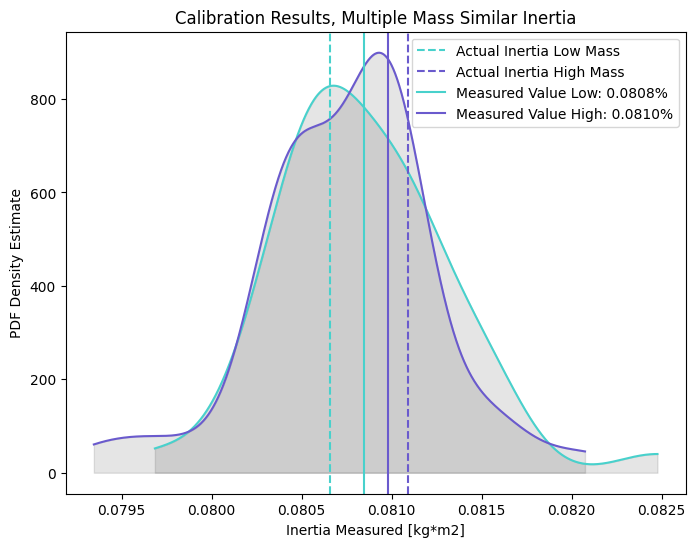

In [6]:
 print('Actual Inertia (m={} kg): {}'.format(2*.4465,actual_inertias['.4465']))
print('Measured Inertia (m={} kg): {}'.format(2*.4465,np.mean(inertia_data['.4465'])))
print('Percent Error (m={} kg): {}%'.format(2*.4465,100*((np.median(inertia_data['.4465'])-actual_inertias['.4465'])/(actual_inertias['.4465']))))
print('Actual Inertia (m={} kg): {}'.format(2*1.176,actual_inertias['1.176']))
print('Measured Inertia (m={} kg): {}'.format(2*1.176,np.mean(inertia_data['1.176'])))
print('Percent Error (m={} kg): {}%'.format(2*1.176,100*((np.median(inertia_data['1.176'])-actual_inertias['1.176'])/(actual_inertias['1.176']))))

error_low = ((inertia_data['.4465']-actual_inertias['.4465'])/(actual_inertias['.4465']))*100
error_high = ((inertia_data['1.176']-actual_inertias['1.176'])/(actual_inertias['1.176']))*100
# kde_low = gaussian_kde(error_low)
# xi_low = np.linspace(np.min(error_low),np.max(error_low),1000)
# kde_high = gaussian_kde(error_high)
# xi_high = np.linspace(np.min(error_high),np.max(error_high),1000)
kde_low = gaussian_kde(inertia_data['.4465'])
xi_low = np.linspace(np.min(inertia_data['.4465']),np.max(inertia_data['.4465']),1000)
kde_high = gaussian_kde(inertia_data['1.176'])
xi_high = np.linspace(np.min(inertia_data['1.176']),np.max(inertia_data['1.176']),1000)


plt.figure(figsize=(8,6))
plt.plot(xi_low,kde_low(xi_low),linestyle='-',c='mediumturquoise')
plt.fill_between(xi_low,kde_low(xi_low),color='k',alpha=0.1)
plt.plot(xi_high,kde_high(xi_high),linestyle='-',c='slateblue')
plt.fill_between(xi_high,kde_high(xi_high),color='k',alpha=0.1)
plt.axvline(x=actual_inertias['.4465'],linestyle='--',c='mediumturquoise',label='Actual Inertia Low Mass')
plt.axvline(x=actual_inertias['1.176'],linestyle='--',c='slateblue',label='Actual Inertia High Mass')
# plt.axvline(x=0,c='k',linestyle='--')
# plt.axvline(x=np.median(error_low),linestyle='-',c='mediumturquoise',label='Percent Error Low: {:.4f}%'.format(np.median(error_low)))
# plt.axvline(x=np.median(error_high),linestyle='-',c='slateblue',label='Percent Error Hgih: {:.4f}%'.format(np.median(error_high)))
plt.axvline(x=np.median(inertia_data['.4465']),linestyle='-',c='mediumturquoise',label='Measured Value Low: {:.4f}%'.format(np.median(inertia_data['.4465'])))
plt.axvline(x=np.median(inertia_data['1.176']),linestyle='-',c='slateblue',label='Measured Value High: {:.4f}%'.format(np.median(inertia_data['1.176'])))
plt.legend()
plt.xlabel('Inertia Measured [kg*m2]')
# plt.xlabel('Percent Error in Inertia Measured')
plt.ylabel('PDF Density Estimate')
plt.title('Calibration Results, Multiple Mass Similar Inertia')
print(kde_high(xi_high))
